In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

### VARIABLEs INCLUDED and the REASONING - more LOGIC and ANALYSES to support this can be found in later cells.

#### The main approach here is to -
- Create composite variables.
- Standardize the newly derived composite-variables and derive the VIF values and the correlation matrix for the normalized composite-variables.
- Run a drop-1 test on the modified data.
- Inspect correlation/VIF values along with drop-1 test to understand which of the significant predictors to retain.
- Run ridge-regression on the retained variables and plot ridge and lasso traces.


#### Reasoning

Among the significant predictors (based on drop-1 test results):

- violent_crimes
- property_crimes
- white_collar_financial_crimes
- public_order_crimes
- central_business_district_index
- urban_suburban_spectrum_indicator

the following had displayed high VIF.

- white_collar_financial_crimes
- violent_crimes
- central_business_district_index
- property_crimes


Thinking through which variables could be dropped for further analyses.

white_collar_financial_crimes:- central_business_district_index can be said to be highly correlated with incidences of white_collar_financial_crimes. There could be a fork relationship here: both have moderate correlation with trips and it is expected that white collar financial crimes would be more prevalent in more commercialised areas. Hence, we will retain white_collar_financial_crimes.

violent_crimes and property_crimes - Both of these have correlation with central_business_district_index too, with both crimes expected to be slightly more prevalent in areas that rank higher on this index. central_business_district_index itself has moderate correlation with trips. There might be a fork relationship here as well - violent_crimes and property_crimes being more prevalent in more commercialised areas, and all of them having an impact on trips. So, we would include both of these in the model. This relationship may at first sound counter-intuitive. However, it is possible that more commercialised areas have 'more reportings' if not 'higher incidences' of violent and property crimes, as it is expected that media outlets would prefer to focus on such stories to attract more readership.

Hence, let's proceed with all the significant variables (based on drop-1) in the model despite the multi-collinearity. 
So all of the following variables will be included.
- violent_crimes
- property_crimes
- white_collar_financial_crimes
- public_order_crimes
- central_business_district_index
- urban_suburban_spectrum_indicator


In [2]:
bike_data = pd.read_csv('bike.csv')

### Clubbing different types of crimes under broader categories

In [3]:
category_2_crime_dict = dict()

category_2_crime_dict["violent_crimes"] = [
    "HOMICIDE",
    "ASSAULT",
    "BATTERY",
    "KIDNAPPING"    
]
category_2_crime_dict["harrassment_crimes"] = [

    "INTIMIDATION",
    "STALKING"
]
category_2_crime_dict["property_crimes"] = [
    "BURGLARY",
    "MOTOR_VEHICLE_THEFT",
    "THEFT",
    "ARSON",
    "CRIMINAL_DAMAGE",
    "CRIMINAL_TRESPASS",
    "ROBBERY"
    
]
category_2_crime_dict["sex_crimes"] = [
    "CRIM_SEXUAL_ASSAULT",
    "SEX_OFFENSE",
    "PROSTITUTION",
    "HUMAN_TRAFFICKING",
    "PUBLIC_INDECENCY"    
]
category_2_crime_dict["drug_related_crimes"] = [
    "NARCOTICS",
    "OTHER_NARCOTIC_VIOLATION"
]
category_2_crime_dict["white_collar_financial_crimes"] = [

    "DECEPTIVE_PRACTICE"
    
]
category_2_crime_dict["weapons_offenses"] = [

    "WEAPONS_VIOLATION",
    "CONCEALED_CARRY_LICENSE_VIOLATIO"
    
]
category_2_crime_dict["public_order_crimes"] = [

    "PUBLIC_PEACE_VIOLATION",
    "GAMBLING",
    "LIQUOR_LAW_VIOLATION",
    "INTERFERENCE_WITH_PUBLIC_OFFICER"

]
category_2_crime_dict["crimes_against_children"] = [
    "OFFENSE_INVOLVING_CHILDREN"
]
category_2_crime_dict["miscellaneous_crimes"] = [

    "OBSCENITY",
    "OTHER_OFFENSE"    
]

### Repeating this process for variables related to location as well.

In [4]:
category_2_area_dict = dict()

category_2_area_dict["central_business_district_index"] = [

    "CBD",
    "Limited_Business_License",
    "Retail_Food_Establishment",
    "CAPACITY"
]
category_2_area_dict["transportation_accessibility_index"] = [

    "CTA_BUS_STATIONS",
    "CTA_TRAIN_STATIONS"
    
]
category_2_area_dict["urban_suburban_spectrum_indicator"] = [

    "PARK_AREA_ACRES",
    "POPULATION_SQ_MILE",
    "BIKE_ROUTES"    
    
]
category_2_area_dict["socioeconomic_status_indicator"] = [

    "PER_CAPITA_INCOME",
    "MINORITY"
    
]

In [5]:
bike_data_selected = bike_data.drop(['ID', 'i'], axis=1)

In [6]:
correlation_matrix = bike_data_selected.corr()


In [7]:
corr_with_trips = correlation_matrix['trips'].sort_values(ascending=False)
print(f"Correlations for {corr_with_trips[:7]}:")

Correlations for trips                        1.000000
CAPACITY                     0.594428
Retail_Food_Establishment    0.593184
Limited_Business_License     0.560613
THEFT                        0.551326
DECEPTIVE_PRACTICE           0.528705
CBD                          0.526904
Name: trips, dtype: float64:


Create a dataframe where the columns are composites of other predictors/variables

In [8]:
bike_composite = pd.DataFrame()

In [9]:
for key, cols in category_2_crime_dict.items():
    bike_composite[key] = bike_data[ cols  ].mean( axis = 1 )

# bike_composite.head()

In [10]:
for key, cols in category_2_area_dict.items():
    bike_composite[key] = bike_data[ cols  ].mean( axis = 1 )

bike_composite.head()

,violent_crimes,harrassment_crimes,property_crimes,sex_crimes,drug_related_crimes,white_collar_financial_crimes,weapons_offenses,public_order_crimes,crimes_against_children,miscellaneous_crimes,central_business_district_index,transportation_accessibility_index,urban_suburban_spectrum_indicator,socioeconomic_status_indicator
0,3.782505,1.497866,5.253022,2.402420,2.654134,7.036148,1.522261,2.449698,3.178054,2.734030,134426.50,118.0,12575.538866,32763.119408
1,2.743382,1.098612,4.649653,1.315850,1.791759,5.587249,0.346574,1.334385,1.945910,2.381087,17628.25,79.0,9376.422367,32763.069917
2,3.142549,0.693147,4.303136,1.221850,2.152033,4.553877,1.545521,1.408697,3.091042,2.393746,20101.75,67.5,9631.812669,32763.421953
3,3.258730,0.693147,4.507747,1.416342,2.402011,4.454347,1.818793,1.599232,2.995732,2.488367,11368.50,74.0,9711.469615,44334.932756
4,3.305614,0.000000,5.043972,1.229694,1.985146,5.587249,1.198948,1.724426,0.693147,2.292484,15685.00,78.0,8516.434553,32763.202079


### Given the widely different scales for the variables, let's standardize them.

In [11]:
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# bike_composite['trips'] = bike_data['trips']
bike_composite_normalized = pd.DataFrame(scaler.fit_transform(bike_composite), columns = bike_composite.columns)
bike_composite_normalized.head()

,violent_crimes,harrassment_crimes,property_crimes,sex_crimes,drug_related_crimes,white_collar_financial_crimes,weapons_offenses,public_order_crimes,crimes_against_children,miscellaneous_crimes,central_business_district_index,transportation_accessibility_index,urban_suburban_spectrum_indicator,socioeconomic_status_indicator
0,1.239313,1.028713,1.175994,2.128938,1.034912,1.535902,0.616536,1.388944,1.136838,0.415519,1.468148,0.951839,1.343113,0.631055
1,-0.582588,0.369963,0.074633,0.024254,-0.533186,0.024276,-1.696299,-0.353799,-0.707463,-0.373683,-0.504545,-0.365858,0.593409,0.631050
2,0.117273,-0.299036,-0.557883,-0.157825,0.121916,-1.053832,0.662293,-0.237681,1.006597,-0.345377,-0.462768,-0.754410,0.653259,0.631084
3,0.320976,-0.299036,-0.184395,0.218906,0.576464,-1.157670,1.199879,0.060042,0.863935,-0.133799,-0.610271,-0.534793,0.671926,1.755197
4,0.403177,-1.442696,0.794405,-0.142631,-0.181542,0.024276,-0.019493,0.255664,-2.582627,-0.571805,-0.537366,-0.399645,0.391873,0.631063


### Variable selection process and justifications

In [12]:
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = bike_composite_normalized.select_dtypes(include=[np.number])  # Select numeric columns
# X = bike_composite.select_dtypes(include=[np.number])  # Select numeric columns

# Add a constant term to the predictors
X = add_constant(X)

# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Sort the dataframe by VIF in descending order
vif_data = vif_data.sort_values("VIF", ascending=False)

# Display the VIF results
print(vif_data[:-1])

                              Variable       VIF
6        white_collar_financial_crimes  8.753918
1                       violent_crimes  8.324619
12  transportation_accessibility_index  7.916262
11     central_business_district_index  7.771529
3                      property_crimes  6.422962
8                  public_order_crimes  5.840298
4                           sex_crimes  5.241250
5                  drug_related_crimes  4.836818
10                miscellaneous_crimes  4.186070
7                     weapons_offenses  3.786115
2                   harrassment_crimes  3.019494
9              crimes_against_children  2.041083
13   urban_suburban_spectrum_indicator  1.439726
14      socioeconomic_status_indicator  1.076220


The following have a higher than 5 VIF:

- white_collar_financial_crimes,
- violent_crimes,
- transportation_accessibility_index,
- central_business_district_index,
- property_crimes,
- public_order_crimes,

indicating that these have relatively higher correlation with the other predictors/variables.

And the following variables were found to have lower/moderate VIF:

- sex_crimes
- drug_related_crimes
- miscellaneous_crimes
- weapons_offenses
- harrassment_crimes
- crimes_against_children
- urban_suburban_spectrum_indicator
- socioeconomic_status_indicator




On encountering predictors with reasonably high VIFs, one of the next steps is to analyse the context-specific relationship between the predictors to try to decide whether to include them in the model, or drop them altogether.

However, let's analyse drop-1 results as well as the variables' correlation-matrix first.

In [13]:
scaler = StandardScaler()
bike_composite_normalized['trips'] = pd.DataFrame(scaler.fit_transform(bike_data[ ["trips"] ]), columns = ['trips'])



We can see this through a visualisation of the correlation matrix as well.

In [14]:
correlation_matrix = bike_composite_normalized.corr()
correlation_matrix

,violent_crimes,harrassment_crimes,property_crimes,sex_crimes,drug_related_crimes,white_collar_financial_crimes,weapons_offenses,public_order_crimes,crimes_against_children,miscellaneous_crimes,central_business_district_index,transportation_accessibility_index,urban_suburban_spectrum_indicator,socioeconomic_status_indicator,trips
violent_crimes,1.000000,0.591691,0.792253,0.695617,0.809282,0.657907,0.799269,0.757890,0.618480,0.815815,0.451455,0.662820,0.191694,0.025014,-0.011469
harrassment_crimes,0.591691,1.000000,0.602954,0.674450,0.504959,0.701432,0.413669,0.598025,0.303355,0.570855,0.728732,0.684212,0.230149,0.082947,0.339513
property_crimes,0.792253,0.602954,1.000000,0.790924,0.708616,0.814980,0.587321,0.791470,0.418534,0.755113,0.476611,0.723968,0.388855,0.069824,0.209129
sex_crimes,0.695617,0.674450,0.790924,1.000000,0.661458,0.853307,0.502951,0.804240,0.353163,0.703782,0.668038,0.794997,0.327625,0.086752,0.377540
drug_related_crimes,0.809282,0.504959,0.708616,0.661458,1.000000,0.551923,0.758093,0.805516,0.539194,0.664986,0.325389,0.594478,0.323876,-0.020763,0.010194
white_collar_financial_crimes,0.657907,0.701432,0.814980,0.853307,0.551923,1.000000,0.398559,0.737921,0.257678,0.708714,0.760621,0.851398,0.308352,0.110417,0.528705
weapons_offenses,0.799269,0.413669,0.587321,0.502951,0.758093,0.398559,1.000000,0.679970,0.559923,0.608658,0.258088,0.493407,0.222374,-0.034764,-0.132591
public_order_crimes,0.757890,0.598025,0.791470,0.804240,0.805516,0.737921,0.679970,1.000000,0.376813,0.720842,0.541521,0.752742,0.354742,0.024854,0.297616
crimes_against_children,0.618480,0.303355,0.418534,0.353163,0.539194,0.257678,0.559923,0.376813,1.000000,0.559249,0.090895,0.314621,0.078562,0.000917,-0.246415
miscellaneous_crimes,0.815815,0.570855,0.755113,0.703782,0.664986,0.708714,0.608658,0.720842,0.559249,1.000000,0.445726,0.663910,0.209571,0.092386,0.103838


### Evaluating correlation between the newly formed composite variables and trips

In [15]:
corr_with_trips = correlation_matrix['trips'].sort_values(ascending=False)
print(f"Correlations for {corr_with_trips}:")

Correlations for trips                                 1.000000
central_business_district_index       0.567670
white_collar_financial_crimes         0.528705
transportation_accessibility_index    0.450481
sex_crimes                            0.377540
harrassment_crimes                    0.339513
public_order_crimes                   0.297616
urban_suburban_spectrum_indicator     0.214696
property_crimes                       0.209129
miscellaneous_crimes                  0.103838
socioeconomic_status_indicator        0.081194
drug_related_crimes                   0.010194
violent_crimes                       -0.011469
weapons_offenses                     -0.132591
crimes_against_children              -0.246415
Name: trips, dtype: float64:


None of the variables have too high a correlation with trips. 
However, 
- central_business_district_index
- white_collar_financial_crimes
- transportation_accessibility_index

have relatively higher correlations.




Let's also run a drop1 test and try to interpret the values in conjunction with VIF and correlation values.


Deciding on which variables to include

In [16]:
# Single term deletions

# Model:
# trips ~ violent_crimes + harrassment_crimes + property_crimes + 
#     sex_crimes + drug_related_crimes + white_collar_financial_crimes + 
#     weapons_offenses + public_order_crimes + crimes_against_children + 
#     miscellaneous_crimes + central_business_district_index + 
#     transportation_accessibility_index + urban_suburban_spectrum_indicator + 
#     socioeconomic_status_indicator
#                                    Df Sum of Sq    RSS     AIC F value    Pr(>F)    
# <none>                                          118.12 -249.63                      
# violent_crimes                      1    3.7182 121.83 -242.33  8.9715  0.002983 ** 
# harrassment_crimes                  1    0.0873 118.20 -251.41  0.2106  0.646669    
# property_crimes                     1    3.0519 121.17 -243.98  7.3639  0.007060 ** 
# sex_crimes                          1    0.4097 118.53 -250.59  0.9885  0.320963    
# drug_related_crimes                 1    0.5702 118.69 -250.19  1.3758  0.241794    
# white_collar_financial_crimes       1   17.9517 136.07 -209.19 43.3149 2.231e-10 ***
# weapons_offenses                    1    1.3850 119.50 -248.13  3.3419  0.068584 .  
# public_order_crimes                 1    7.8885 126.01 -232.24 19.0338 1.797e-05 ***
# crimes_against_children             1    0.8989 119.02 -249.36  2.1690  0.141926    
# miscellaneous_crimes                1    0.7709 118.89 -249.68  1.8600  0.173697    
# central_business_district_index     1    3.1478 121.27 -243.74  7.5952  0.006230 ** 
# transportation_accessibility_index  1    0.0356 118.15 -251.54  0.0860  0.769587    
# urban_suburban_spectrum_indicator   1    3.0912 121.21 -243.88  7.4586  0.006707 ** 
# socioeconomic_status_indicator      1    0.0223 118.14 -251.57  0.0538  0.816725    
# ---
# Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Among the significant predictors:

- violent_crimes
- property_crimes
- white_collar_financial_crimes
- public_order_crimes
- central_business_district_index
- urban_suburban_spectrum_indicator

the following had displayed high VIF.

- white_collar_financial_crimes
- violent_crimes
- central_business_district_index
- property_crimes



#### REASONING FOR INCLUSION OF ALL SIGNIFICANT VARIABLEs (also included in the top-most cells)

Thinking through which variables could be dropped for further analyses.

white_collar_financial_crimes:- central_business_district_index can be said to be highly correlated with incidences of white_collar_financial_crimes. There could be a fork relationship here: both have moderate correlation with trips and it is expected that white collar financial crimes would be more prevalent in more commercialised areas. Hence, we will retain white_collar_financial_crimes.

violent_crimes and property_crimes - Both of these have correlation with central_business_district_index too, with both crimes expected to be slightly more prevalent in areas that rank higher on this index. central_business_district_index itself has moderate correlation with trips. There might be a fork relationship here as well - violent_crimes and property_crimes being more prevalent in more commercialised areas, and all of them having an impact on trips. So, we would include both of these in the model. This relationship may at first sound counter-intuitive. However, it is possible that more commercialised areas have 'more reportings' if not 'higher incidences' of violent and property crimes, as it is expected that media outlets would prefer to focus on such stories to attract more readership.

Hence, let's proceed with all the significant variables (based on drop-1) in the model despite the multi-collinearity.


In [17]:
y = bike_composite_normalized['trips']

In [18]:
np.random.seed(0)

In [19]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import RepeatedKFold, cross_val_score
import numpy as np

In [20]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [21]:
alphas = np.logspace(-3, 3, 100)  # Example range

In [22]:
model = RidgeCV(alphas=alphas, cv=cv, scoring='neg_mean_squared_error')
model.fit(
    X[
    ["violent_crimes", "property_crimes", "white_collar_financial_crimes",\
     "public_order_crimes", "central_business_district_index", "urban_suburban_spectrum_indicator"]  ], 
    y)

RidgeCV(alphas=array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6.13590727e-03, 7.05480231e-03, 8.11130831e-03,
       9.32603347e-03, 1.07226722e-02, 1.23284674e-02, 1.41747416e-02,
       1.62975083e-02, 1.87381742e-0...
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03]),
        cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1),
        scoring='neg_mean_squared_error')

In [23]:
best_alpha = model.alpha_
best_alpha

2.848035868435802

In [24]:
final_model = Ridge(alpha=best_alpha)
final_model.fit(X[["violent_crimes", "property_crimes", "white_collar_financial_crimes", \
                   "public_order_crimes", "central_business_district_index", "urban_suburban_spectrum_indicator"]  ], y)

Ridge(alpha=2.848035868435802)

In [25]:
scores = cross_val_score(final_model, X[["violent_crimes", "property_crimes", "white_collar_financial_crimes",\
                                         "public_order_crimes", "central_business_district_index", "urban_suburban_spectrum_indicator"]  ], y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

### Building the ridge and lasso trace plots

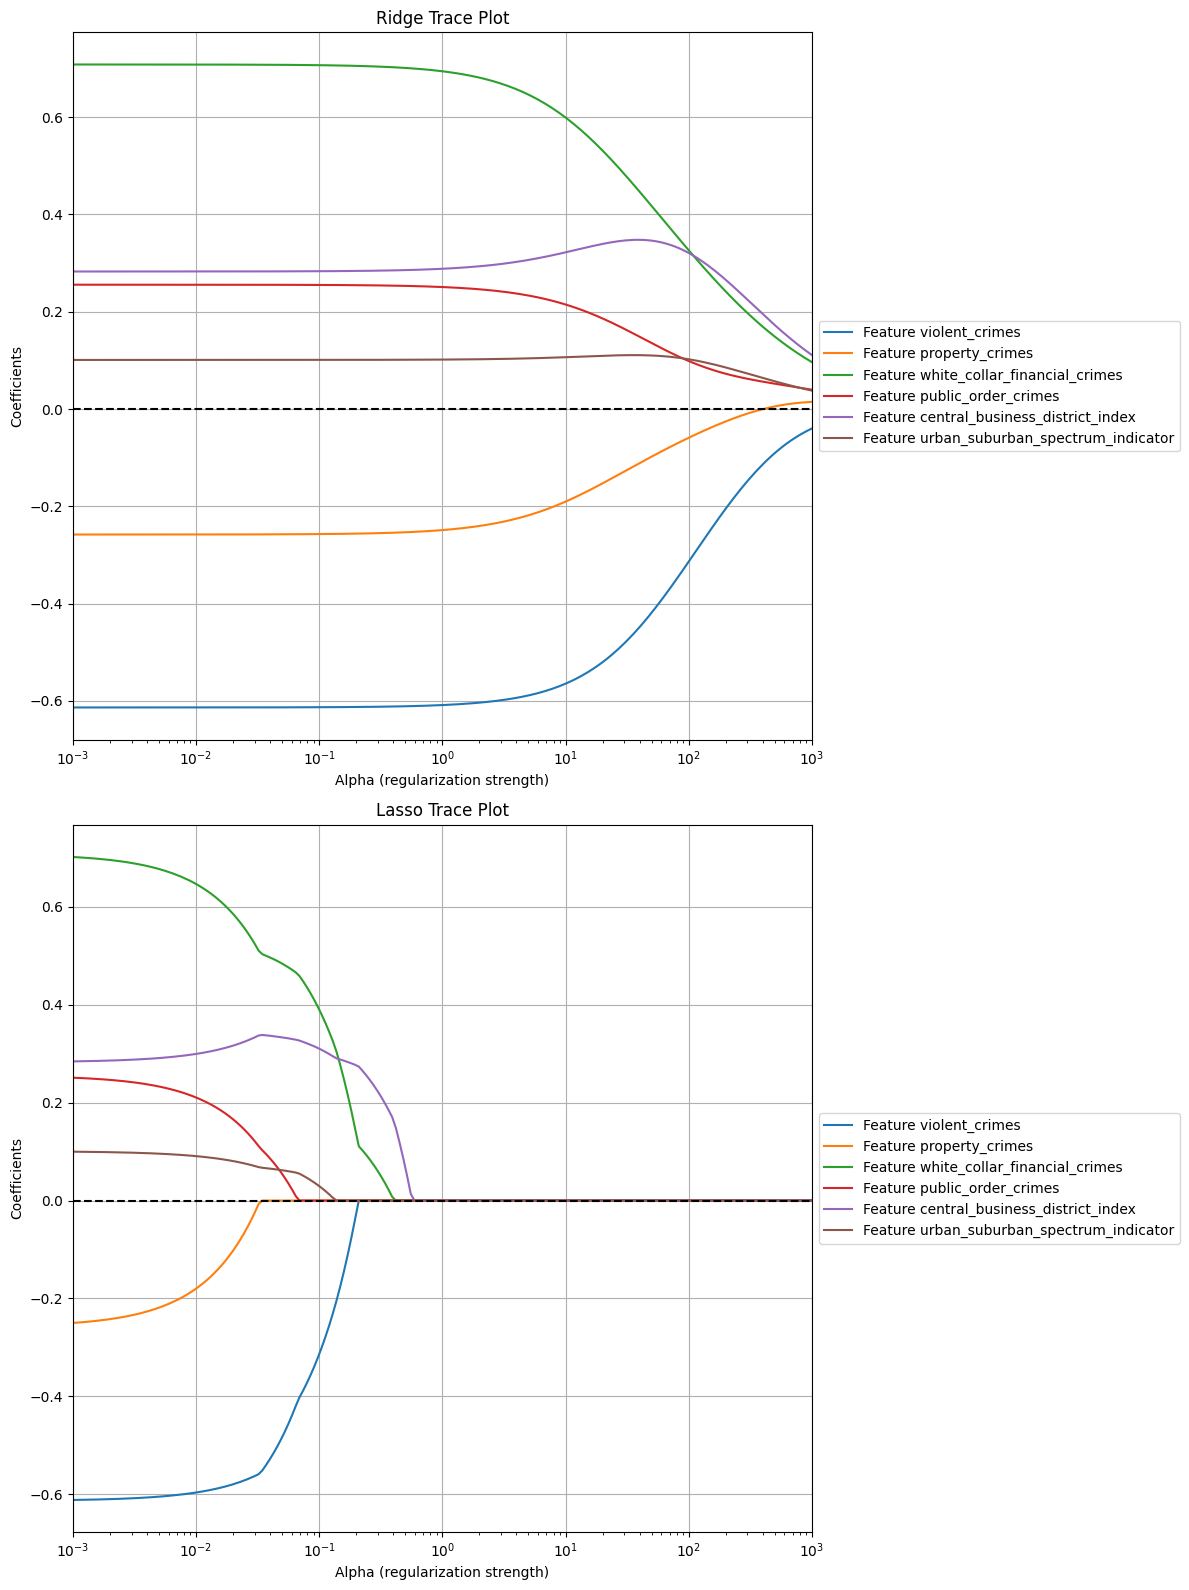

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression

# # Generate sample data
# X, y = make_regression(n_samples=100, n_features=10, noise=0.1, random_state=42)
cols = X[["violent_crimes", "property_crimes", "white_collar_financial_crimes", "public_order_crimes", \
          "central_business_district_index", "urban_suburban_spectrum_indicator"]  ].columns

# # Standardize features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# Define range of alpha values
alphas = np.logspace(-3, 3, 200)

# Function to fit model and get coefficients
def get_coefs(model_class, alphas, X, y):
    coefs = []
    for alpha in alphas:
        model = model_class(alpha=alpha)
        model.fit(X, y)
        coefs.append(model.coef_)
    return np.array(coefs)

# Get coefficients for Ridge and Lasso
ridge_coefs = get_coefs(Ridge, alphas, X[["violent_crimes", "property_crimes", "white_collar_financial_crimes", \
                                          "public_order_crimes", "central_business_district_index", "urban_suburban_spectrum_indicator"]  ], y)
lasso_coefs = get_coefs(Lasso, alphas, X[["violent_crimes", "property_crimes", "white_collar_financial_crimes",\
                                          "public_order_crimes", "central_business_district_index", "urban_suburban_spectrum_indicator"]  ], y)

# Function to plot trace
def plot_trace(ax, alphas, coefs, title):
    for i in range(X[["violent_crimes", "property_crimes", "white_collar_financial_crimes",\
                      "public_order_crimes", "central_business_district_index", "urban_suburban_spectrum_indicator"]  ].shape[1]):
        ax.semilogx(alphas, coefs[:, i], label=f'Feature {cols[i]}')
    ax.set_xlabel('Alpha (regularization strength)')
    ax.set_ylabel('Coefficients')
    ax.set_title(title)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(True)
    ax.axhline(y=0, color='k', linestyle='--')
    ax.set_xlim(alphas.min(), alphas.max())

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

# Plot Ridge trace
plot_trace(ax1, alphas, ridge_coefs, 'Ridge Trace Plot')

# Plot Lasso trace
plot_trace(ax2, alphas, lasso_coefs, 'Lasso Trace Plot')

plt.tight_layout()
plt.show()

Based on observations from all the analyses:

Our conclusion about property_crimes affecting trips is unstable.

Our conclusions for the following being important predictors can be said to be reasonable -
- Violent crimes,
- white collar financial crimes,
- public order crimes,
- property crimes,
- central business district index
- urban suburban spectrum indicator 


However, here are some rather unintuitive observations:
- 'white collar financial crimes' affecting trips instead of a variable like 'sex crimes'
- 'harrassment crimes' and 'transportation_accessibility_index' not being significant